https://www.kaggle.com/jainamshah17/pytorch-starter-image-classification

https://www.kaggle.com/prithwirajmitra/covid-face-mask-detection-dataset

https://www.kaggle.com/sergeiboltovskii/baseline-in-pytorch

In [13]:
!unzip mask_archive.zip > /dev/null
!mv 'New Masks Dataset' masks
# !rm -rf mask_archive.zip sample_data

In [14]:
import torch
import os
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import cv2
import numpy as np
from torch.utils.data import RandomSampler
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torchvision.models as models
import torch.nn as nn
import time
import torch.nn.functional as F

In [15]:
DIR_TRAIN = "./masks/Train/"
DIR_VALID = "./masks/Validation/"
DIR_TEST = "./masks/Test/"

In [16]:
classes = os.listdir(DIR_TRAIN)

train_count = 0
valid_count = 0
test_count = 0

for _class in classes:
    train_count += len(os.listdir(DIR_TRAIN + _class))
    valid_count += len(os.listdir(DIR_VALID + _class))
    test_count += len(os.listdir(DIR_TEST + _class))

In [17]:
print("Total Classes: ",len(classes))
print("Total train images: ",train_count)
print("Total valid images: ",valid_count)
print("Total test images: ",test_count)


Total Classes:  2
Total train images:  600
Total valid images:  306
Total test images:  100


In [18]:
train_imgs = []
valid_imgs = []
test_imgs = []

for _class in classes:
    
    for img in os.listdir(DIR_TRAIN + _class):
        train_imgs.append(DIR_TRAIN + _class + "/" + img)
    
    for img in os.listdir(DIR_VALID + _class):
        valid_imgs.append(DIR_VALID + _class + "/" + img)
        
    for img in os.listdir(DIR_TEST + _class):
        test_imgs.append(DIR_TEST + _class + "/" + img)

class_to_int = {classes[i] : i for i in range(len(classes))}

In [19]:
class_to_int

{'Mask': 1, 'Non Mask': 0}

In [20]:
img_size = 148

def get_transform():
    # return T.Compose([T.Resize((img_size, img_size)), T.ToTensor()])
    return T.Compose([T.ToPILImage(), T.Resize((img_size, img_size)), T.ToTensor()])

    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(rgb_mean, rgb_std),


class MaskDataset(Dataset):
    
    def __init__(self, imgs_list, class_to_int, transforms):
        
        super().__init__()
        self.imgs_list = imgs_list
        self.class_to_int = class_to_int
        self.transforms = transforms
        
        
    def __getitem__(self, index):
    
        image_path = self.imgs_list[index]
        
        #Reading image
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        #image /= 255.0
        
        #Retriving class label
        label = image_path.split("/")[-2]
        label = self.class_to_int[label]
        
        #Applying transforms on image
        # image = self.transforms(image)
        image = self.transforms(np.uint8(image))

        return image, label
           
    def __len__(self):
        return len(self.imgs_list)

In [26]:
train_dataset = MaskDataset(train_imgs, class_to_int, get_transform())
valid_dataset = MaskDataset(valid_imgs, class_to_int, get_transform())
test_dataset = MaskDataset(test_imgs, class_to_int, get_transform())

train_random_sampler = RandomSampler(train_dataset)
valid_random_sampler = RandomSampler(valid_dataset)
test_random_sampler = RandomSampler(test_dataset)

train_data_loader = DataLoader(
    dataset = train_dataset,
    batch_size = 16,
    sampler = train_random_sampler
)

valid_data_loader = DataLoader(
    dataset = valid_dataset,
    batch_size = 16,
    sampler = valid_random_sampler
)

test_data_loader = DataLoader(
    dataset = test_dataset,
    batch_size = 16,
    sampler = test_random_sampler
)

In [27]:
train_dataset.class_to_int

{'Mask': 1, 'Non Mask': 0}

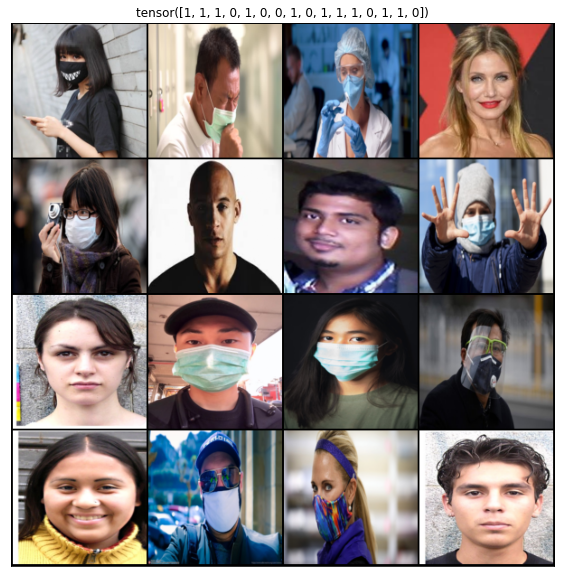

In [28]:
for images, label in train_data_loader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axes.set_title(label)
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break

In [29]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [30]:
def calc_accuracy(true,pred):
    pred = F.softmax(pred, dim = 1).argmax(-1)
    acc = (c == b).sum() / len(c)
    return acc

In [33]:
# new_transform = T.Compose([T.ToPILImage(), T.Resize((img_size, img_size)), 
#                            T.ToTensor()])


In [34]:
def get_predict(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    return new_transform(image)

In [36]:
model = models.resnet50(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters())

In [38]:
train_losses = []
valid_losses = []
acc = []

for epoch in range(1, 3 + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    model.train()
    for data, target in train_data_loader:
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        
    # validate-the-model
    model.eval()
    for data, target in valid_data_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)

        #print(output.argmax(-1), target)
        acc.append(sum(output.argmax(-1) == target)/float(len(target)))

        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_data_loader.sampler)
    valid_loss = valid_loss/len(valid_data_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    print(np.mean(acc))

Epoch: 1 	Training Loss: 0.312405 	Validation Loss: 0.138210
0.9625
Epoch: 2 	Training Loss: 0.202685 	Validation Loss: 0.355513
0.915625
Epoch: 3 	Training Loss: 0.105923 	Validation Loss: 0.131291
0.9270833


In [42]:
a = get_predict('8.jpeg')

model(torch.unsqueeze(a, 0)).argmax(-1)


tensor([1])

In [40]:
train_dataset.class_to_int

{'Mask': 1, 'Non Mask': 0}

In [44]:
torch.save(model.state_dict(), 'model_mask.pickle')